In [40]:
!pip install apricot-select

In [41]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 14074855767640462487, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14638920512
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9435239722524709224
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

In [42]:
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import torch
import torch.optim as optim
from torch.autograd import Variable
import sys
from sklearn.preprocessing import StandardScaler
from copy import deepcopy

from drive.MyDrive.distil.utils.DataHandler import DataHandler_Points
from drive.MyDrive.distil.active_learning_strategies import GLISTER,BADGE,EntropySampling
from drive.MyDrive.distil.utils.models.simpleNN_net import TwoLayerNet
from matplotlib import pyplot as plt

### **Loading data**

In [43]:
def libsvm_file_load(path,dim, save_data=False):
    data = []
    target = []
    with open(path) as fp:
       line = fp.readline()
       while line:
        temp = [i for i in line.strip().split(" ")]
        target.append(int(float(temp[0]))) # Class Number. # Not assumed to be in (0, K-1)
        temp_data = [0]*dim
        
        for i in temp[1:]:
            ind,val = i.split(':')
            temp_data[int(ind)-1] = float(val)
        data.append(temp_data)
        line = fp.readline()
    X_data = np.array(data,dtype=np.float32)
    Y_label = np.array(target)
    if save_data:
        # Save the numpy files to the folder where they come from
        data_np_path = path + '.data.npy'
        target_np_path = path + '.label.npy'
        np.save(data_np_path, X_data)
        np.save(target_np_path, Y_label)
    return (X_data, Y_label)

dset_name = 'ijcnn1'

#User Execution
if dset_name == "satimage":
    trn_file =  "drive/MyDrive/distil/datasets/satimage/satimage.scale.trn"
    val_file = 'drive/MyDrive/distil/datasets/satimage/satimage.scale.val'
    tst_file = 'drive/MyDrive/distil/datasets/satimage/satimage.scale.tst'
    data_dims = 36
    num_cls = 6

    x_trn, y_trn = libsvm_file_load(trn_file, dim=data_dims)
    x_val, y_val = libsvm_file_load(val_file, dim=data_dims)
    x_tst, y_tst = libsvm_file_load(tst_file, dim=data_dims)

    y_trn -= 1  # First Class should be zero
    y_val -= 1
    y_tst -= 1  # First Class should be zero

    sc = StandardScaler()
    x_trn = sc.fit_transform(x_trn)
    x_val = sc.transform(x_val)
    x_tst = sc.transform(x_tst)

elif dset_name == "ijcnn1":
    
    trn_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.trn'
    val_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.val'
    tst_file = 'drive/MyDrive/distil/datasets/ijcnn1/ijcnn1.tst'
    data_dims = 22
    num_cls = 2
    x_trn, y_trn = libsvm_file_load(trn_file, dim=data_dims)
    x_val, y_val = libsvm_file_load(val_file, dim=data_dims)
    x_tst, y_tst = libsvm_file_load(tst_file, dim=data_dims)
    
    # The class labels are (-1,1). Make them to (0,1)
    y_trn[y_trn < 0] = 0
    y_val[y_val < 0] = 0
    y_tst[y_tst < 0] = 0    

    sc = StandardScaler()
    x_trn = sc.fit_transform(x_trn)
    x_val = sc.transform(x_val)
    x_tst = sc.transform(x_tst)

# **Class for training**

In [44]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class data_train:

    def __init__(self, X, Y, net, handler, args):

        self.X = X
        self.Y = Y
        self.net = net
        self.handler = handler
        self.args = args
        self.use_cuda = torch.cuda.is_available()

    def update_index(self, idxs_lb):
        self.idxs_lb = idxs_lb

    def update_data(self, X, Y):
      
      self.X = X
      self.Y = Y
      self.n_pool = len(Y)

    def _train(self, epoch, loader_tr, optimizer):
        self.clf.train()
        accFinal = 0.

        for batch_id, (x, y, idxs) in enumerate(loader_tr):
            if self.use_cuda:
                x, y = Variable(x.cuda()), Variable(y.cuda())
            else:
                x, y = Variable(x), Variable(y)
            optimizer.zero_grad()
            out = self.clf(x)
            loss = F.cross_entropy(out, y)
            accFinal += torch.sum((torch.max(out,1)[1] == y).float()).data.item()
            loss.backward()

            # clamp gradients, just in case
            # for p in filter(lambda p: p.grad is not None, self.clf.parameters()): p.grad.data.clamp_(min=-.1, max=.1)

            optimizer.step()
        return accFinal / len(loader_tr.dataset.X)

    
    def train(self):

        print('Training..')
        def weight_reset(m):
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

        n_epoch = self.args['n_epoch']
        if self.use_cuda:
            self.clf =  self.net.apply(weight_reset).cuda()
        else:
            self.clf =  self.net.apply(weight_reset)

        optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)
        loader_tr = DataLoader(self.handler(self.X, self.Y, False),batch_size =1000)
        epoch = 1
        accCurrent = 0
        while accCurrent < 0.95 and epoch < n_epoch: 
            accCurrent = self._train(epoch, loader_tr, optimizer)
            epoch += 1
            # print(str(epoch) + ' training accuracy: ' + str(accCurrent), flush=True)
            
            if (epoch % 50 == 0) and (accCurrent < 0.2): # resetif not converging
                self.clf = self.net.apply(weight_reset)
                optimizer = optim.Adam(self.clf.parameters(), lr = self.args['lr'], weight_decay=0)

        print('Training accuracy:',round(accCurrent, 3)*100, flush=True) #'Epoch:', str(epoch),
        return self.clf

# **Trainig loop for active learning**

In [45]:
def training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=False):

    flag = False
    if first:

      nSamps, dim = np.shape(X_unlabeled)

      np.random.seed(42)
      start_idxs = np.random.choice(nSamps, size=int(0.01*nSamps), replace=False)

      X_tr = X_unlabeled[start_idxs]
      X_unlabeled = np.delete(X_unlabeled, start_idxs, axis = 0)

      Y_tr = Y_unlabeled[start_idxs]
      Y_unlabeled = np.delete(Y_unlabeled, start_idxs, axis = 0)

      print('Starting set of points -', len(start_idxs))

    else:    

      #Human In Loop, Assuming user adds new labels here
      idx = strategy.select(budget)
      
      #Adding new points to training set
      X_tr = np.concatenate((X_tr, X_unlabeled[idx]), axis=0)
      X_unlabeled = np.delete(X_unlabeled, idx, axis = 0)

      Y_tr = np.concatenate((Y_tr, Y_unlabeled[idx]), axis = 0)
      Y_unlabeled = np.delete(Y_unlabeled, idx, axis = 0)

      print('New data points added -', len(idx))
    
    strategy.update_data(X_tr, Y_tr, X_unlabeled)
    dt.update_data(X_tr, Y_tr)

    clf = dt.train()
    strategy.update_model(clf)
    y_pred = strategy.predict(x_tst).numpy()
    acc = round(1.0 * (y_tst == y_pred).sum().item() / len(y_tst), 3)
    #print('Testing accuracy:', acc, flush=True)
    if acc > 0.98:
        flag = True
        print('Testing accuracy reached above 98%')

    return X_tr,Y_tr,X_unlabeled,Y_unlabeled,acc, flag

# **Uncertanity based Active learning Strategy**

In [46]:
net = TwoLayerNet(data_dims, num_cls,100)
net.apply(init_weights)

strategy_args = {'batch_size' : 1000, 'lr':float(0.001)} 
strategy = EntropySampling(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])    ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

un_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(un_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,un_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(un_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 92.9
Initial Testing accuracy: 90.3
New data points added - 350
Training..
Training accuracy: 95.0
Testing accuracy at 1 round : 94.5
New data points added - 350
Training..
Training accuracy: 87.8
Testing accuracy at 2 round : 91.2
New data points added - 350
Training..
Training accuracy: 90.9
Testing accuracy at 3 round : 94.89999999999999
New data points added - 350
Training..
Training accuracy: 94.1
Testing accuracy at 4 round : 96.7
New data points added - 350
Training..
Training accuracy: 91.2
Testing accuracy at 5 round : 96.6
New data points added - 350
Training..
Training accuracy: 93.10000000000001
Testing accuracy at 6 round : 97.2
New data points added - 350
Training..
Training accuracy: 91.4
Testing accuracy at 7 round : 97.0
New data points added - 350
Training..
Training accuracy: 89.8
Testing accuracy at 8 round : 96.6
New data points added - 350
Training..
Training accuracy: 92.10000000000001
Testing accuracy at

# **GLISTER**

In [47]:
net = TwoLayerNet(data_dims, num_cls,100)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000, 'lr':float(0.001)} 
strategy = GLISTER(None, None, None, net, DataHandler_Points, num_cls, strategy_args,valid=False)#,typeOf='Diversity',lam=10)

args = {'n_epoch':150, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

glister_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(glister_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,glister_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(glister_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 92.60000000000001
Initial Testing accuracy: 91.2
New data points added - 350
Training..
Training accuracy: 88.0
Testing accuracy at 1 round : 90.8
New data points added - 350
Training..
Training accuracy: 91.10000000000001
Testing accuracy at 2 round : 91.4
New data points added - 350
Training..
Training accuracy: 93.30000000000001
Testing accuracy at 3 round : 94.39999999999999
New data points added - 350
Training..
Training accuracy: 92.80000000000001
Testing accuracy at 4 round : 95.1
New data points added - 350
Training..
Training accuracy: 91.3
Testing accuracy at 5 round : 96.0
New data points added - 350
Training..
Training accuracy: 93.30000000000001
Testing accuracy at 6 round : 96.89999999999999
New data points added - 350
Training..
Training accuracy: 91.2
Testing accuracy at 7 round : 96.7
New data points added - 350
Training..
Training accuracy: 90.60000000000001
Testing accuracy at 8 round : 96.6
New data points a

In [48]:
net = TwoLayerNet(data_dims, num_cls,100)
net.apply(init_weights)

strategy_args = {'batch_size' : 12000, 'lr':float(0.001)} 
strategy = BADGE(None, None, None, net, DataHandler_Points, num_cls, strategy_args)

args = {'n_epoch':150, 'lr':float(0.001)}  #Different args than strategy_args
n_rounds = 10    ##Number of rounds to run ac
budget = int(0.01*x_trn.shape[0])     ##Number of new data points after every iteration

#Training Class initialization
dt = data_train(None, None, net, DataHandler_Points, args)

badge_acc = np.zeros(n_rounds+1)
X_unlabeled = deepcopy(x_trn)
Y_unlabeled = deepcopy(y_trn)
X_tr = None
Y_tr = None

X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[0],_ = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst,first=True)
print('Initial Testing accuracy:', round(badge_acc[0], 3)*100, flush=True)

for i in range(n_rounds):
  X_tr,Y_tr,X_unlabeled,Y_unlabeled,badge_acc[i+1],flag = training_round(strategy,dt,X_tr,Y_tr,X_unlabeled,Y_unlabeled,x_tst,y_tst)
  print('Testing accuracy at',i+1,'round :', round(badge_acc[i+1], 3)*100, flush=True)  
  if flag:
    break


Starting set of points - 350
Training..
Training accuracy: 92.0
Initial Testing accuracy: 91.10000000000001
New data points added - 350
Training..
Training accuracy: 90.4
Testing accuracy at 1 round : 92.0
New data points added - 350
Training..
Training accuracy: 89.0
Testing accuracy at 2 round : 92.9
New data points added - 350
Training..
Training accuracy: 92.9
Testing accuracy at 3 round : 95.3
New data points added - 350
Training..
Training accuracy: 92.2
Testing accuracy at 4 round : 96.1
New data points added - 350
Training..
Training accuracy: 91.9
Testing accuracy at 5 round : 96.6
New data points added - 350
Training..
Training accuracy: 93.5
Testing accuracy at 6 round : 97.0
New data points added - 350
Training..
Training accuracy: 92.7
Testing accuracy at 7 round : 97.2
New data points added - 350
Training..
Training accuracy: 92.7
Testing accuracy at 8 round : 97.1
New data points added - 350
Training..
Training accuracy: 93.5
Testing accuracy at 9 round : 97.2
New data p

Text(0.5, 1.0, 'IJCNN')

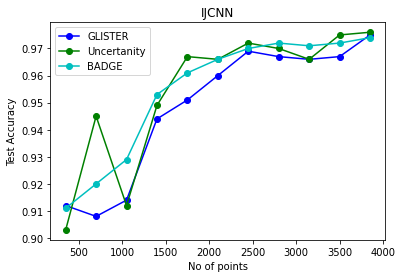

In [49]:
x_axis = np.array([budget for i in range(n_rounds+1)])
x_axis = x_axis*np.array([i for i in range(1,n_rounds+2)])
plt.figure()
plt.plot(x_axis, glister_acc, 'b-', label='GLISTER',marker='o')
plt.plot(x_axis, un_acc, 'g-', label='Uncertanity',marker='o')
plt.plot(x_axis, badge_acc, 'c', label='BADGE',marker='o')


plt.legend()
plt.xlabel('No of points')
plt.ylabel('Test Accuracy')
plt.title('IJCNN')